## Installing Dependencies

Note, please make sure all external packages are downloaded onto your computer before running this notebook. Otherwise, the notebook will error out

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import glob
import os
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from pygam import LogisticGAM
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
import eli5
from eli5.permutation_importance import get_score_importances
import warnings

In [61]:
warnings.filterwarnings('ignore')

## Outline of Notebook

* Data Processing & cleaning
* EDA and Visualizations
* Models

### Consolidate Washington Post, Mapping Police Violence, and Fatal Encounters Data Sets

In [28]:
# Emil's Data upload & Cleaning for fatal encounters data
post = pd.read_csv('data/washington post police killings.csv')
mpv = pd.read_csv('data/mapping police violence.csv')
fatal = pd.read_csv('data/fatal encounters.csv')

# cast ID columns to int
mpv['WaPo ID'] = mpv['WaPo ID (If included in WaPo database)'].fillna(0).astype(int)
mpv.drop('WaPo ID (If included in WaPo database)', axis=1,inplace=True)
mpv['Fatal Encounters ID'] = mpv['Fatal Encounters ID'].fillna(0).astype(int)
mpv['MPV ID'] = mpv['MPV ID'].fillna(0).astype(int)
fatal['Unique ID'] = fatal['Unique ID'].fillna(0).astype(int)

# cast date columns to datetime
mpv['Date of Incident (month/day/year)'] = pd.to_datetime(mpv['Date of Incident (month/day/year)'])
fatal['Date of injury resulting in death (month/day/year)'] = pd.to_datetime(fatal['Date of injury resulting in death (month/day/year)'])
post['date'] = pd.to_datetime(post['date'])

post.shape, mpv.shape, fatal.shape

# identify records in MPV that aren't in Fatal Encounters or Washington Post
mpv_addToFatal = mpv[(mpv['Fatal Encounters ID'] == 0) & (mpv['WaPo ID'] == 0)]
mpv2 = mpv[(mpv['Fatal Encounters ID'] == 0) & (mpv['WaPo ID'] != 0)].copy()
mpv3 = mpv2[mpv2['WaPo ID'].isin(post.id)==False]
mpv_addToFatal = mpv_addToFatal.append(mpv3)



# check to make sure we're not adding duplicates (using date and name of victim)
dups_mpv_addToFatal = fatal.merge(mpv_addToFatal, left_on=['Date of injury resulting in death (month/day/year)', 'Name'], right_on=['Date of Incident (month/day/year)','Victim name'])['Victim name']
mpv_addToFatal = mpv_addToFatal[mpv_addToFatal['Victim name'].isin(dups_mpv_addToFatal)==False]

# identify records in WaPo that aren't in MPV
post_addToFatal = post[post.id.isin(mpv['WaPo ID'])==False]

# check to make sure we're not adding duplicates (using date and name of victim)
dups_post_addToFatal = fatal.merge(post_addToFatal, left_on=['Date of injury resulting in death (month/day/year)', 'Name'], right_on=['date','name'])['name']
post_addToFatal = post_addToFatal[post_addToFatal['name'].isin(dups_post_addToFatal)==False]

# get the interesting descriptive variables that are in MPV but aren't in Fatal Encounters
mpv_fatal_merge = mpv.loc[mpv['Fatal Encounters ID'] != 0,['Fatal Encounters ID','Official disposition of death (justified or other)','Criminal Charges?','Symptoms of mental illness?','Unarmed/Did Not Have an Actual Weapon','Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)','Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)','Body Camera (Source: WaPo)']]
mpv_fatal_merge.drop_duplicates(subset='Fatal Encounters ID',inplace=True)
fatal_updated = fatal.merge(mpv_fatal_merge, left_on='Unique ID', right_on='Fatal Encounters ID', how='left')
#fatal_updated.to_csv('/Users/erg1/Desktop/CS 109 - Intro to DS/final project/fatal encounters merged with MPV to get descriptive vars.csv',index=False)

# send records to add to Fatal Encounters to a spreadsheet because it'll be easier to append the rows in Excel
#post_addToFatal.to_csv('/Users/erg1/Desktop/CS 109 - Intro to DS/final project/washinton post records not in fatal encounters.csv',index=False)
#mpv_addToFatal.to_csv('/Users/erg1/Desktop/CS 109 - Intro to DS/final project/MPV records not in fatal encounters.csv',index=False)

### Merge Police Killings Data with County Demographics Data and Police Department Data

In [29]:
# Create final merged dataframe with all predictors and necessary features to create a response variable
# read our cleaned datasets
county_preds = pd.read_csv('data/county preds data (no police dems).csv')
violence_df = pd.read_csv('data/police violence since 01-01-2012.csv')
state_names = pd.read_csv('data/state names and abbreviations.csv')
police_dems = pd.read_csv('data/police dems and policies.csv')
police_dems.drop(['PERS_NEW_TOTS','PERS_MALE','PERS_FEMALE','PERS_SUP_SGT_TOTS','PERS_COLBAR_LIM','PERS_COLBAR_NON'],axis=1,inplace=True)

# drop rows where the county is empty, upper case the county column for the merge, and merge with state_names because the veiolence_df only has the abbreviated names
violence_df.dropna(subset=['Location of death (county)'],inplace=True)
violence_df['COUNTY'] = violence_df['Location of death (county)'].apply(lambda x: x.upper())
violence_df = violence_df.copy().merge(state_names, left_on='State', right_on='state_abbr')

# Split the police angency column because many rows have multiple police agencies
violence_df2 = violence_df.copy()
violence_df2[['police_agency1','police_agency2','police_agency3','police_agency4','police_agency5','police_agency6','police_agency7','police_agency8']] = violence_df2['Agency or agencies involved'].str.split(', ',expand=True)
violence_df2['police_agency1'] = violence_df2['police_agency1'].apply(lambda x: x.upper())

# aggregate the police violence data, creating 2 dfs, one aggregated by race and the other just total
violence_agg_df = violence_df2.groupby(['police_agency1','COUNTY','state_name','Race with imputations']).ID.count().reset_index()
violence_agg_df_total = violence_df2.groupby(['police_agency1','COUNTY','state_name']).ID.count().reset_index()

# merge the police violence dfs with the county demographic predictors df
violence_agg_dems_df = violence_agg_df.merge(county_preds, left_on=['COUNTY','state_name'], right_on=['COUNTY','State'])
violence_agg_dems_df_total = violence_agg_df_total.merge(county_preds, left_on=['COUNTY','state_name'], right_on=['COUNTY','State'])

# pull in state names into police demographics because it only has abbreviations
police_dems2 = police_dems.copy().merge(state_names,left_on='STATE',right_on='state_abbr')

# now merge to pull in police demographics
violence_agg_county_police_dems_df_total = violence_agg_dems_df_total.merge(police_dems2, left_on=['police_agency1','state_name','FIPS'], right_on=['AGENCYNAME','state_name','FIPS'])

# calculate violence rate per million people served
violence_agg_county_police_dems_df_total['violence_rate_popserved'] = (violence_agg_county_police_dems_df_total['ID']/violence_agg_county_police_dems_df_total['POPSERVED'])*1000000

#drop redundant columns
total_df = violence_agg_county_police_dems_df_total.drop(['state_name','STATE','AGENCYNAME'],axis=1).copy()


### Process data to prep for EDA

In [30]:
# DEAL WITH -8 AND -9, WHICH INDICATE MISSING VALUES FROM THE POLICE DATASET
pol_vars = ['NUMCPO','CP_MISSION','CP_PLAN','CP_TRN_NEW','CP_CPACAD','CP_TRN_INSRV',
'ISSU_ADDR_CP','EQ_AUTH_NECK','EQ_AUTH_CHEM','POL_MAXHRS','POL_MENTILL','POL_INCUSDTH',
'POL_RACPROF','POL_ACTSHOOT','POL_STFRSK','POL_FOOT','POL_MSCOND','POL_BWC','POL_CULTAW',
'POL_INV_INJRY','POL_INV_DTH','POL_CCRB','ISSU_ADDR_CRMPREV', 
'PERS_NEW_WHT','PERS_NEW_BLK','PERS_NEW_HSP','PERS_NEW_IND','PERS_NEW_ASN',
'PERS_NEW_HAW','PERS_NEW_TWO','PERS_NEW_UNK','PERS_NEW_TOTR','PERS_NEW_MALE',
'PERS_NEW_FEM','PERS_WHITE_MALE','PERS_BLACK_MALE','PERS_HISP_MALE','PERS_AMIND_MALE',
'PERS_ASIAN_MALE','PERS_HAWPI_MALE','PERS_MULTI_MALE','PERS_UNK_MALE','PERS_WHITE_FEM','PERS_BLACK_FEM',
'PERS_HISP_FEM','PERS_AMIND_FEM','PERS_ASIAN_FEM','PERS_HAWPI_FEM','PERS_UNK_FEM',
'PERS_SUP_SGT_WH','PERS_SUP_SGT_BK','PERS_SUP_SGT_HS','PERS_SUP_SGT_AI',
'PERS_SUP_SGT_AS','PERS_SUP_SGT_HA','PERS_SUP_SGT_MUL','PERS_SUP_SGT_UNK','PERS_SUP_SGT_TOTR',
'PERS_SUP_SGT_MALE','PERS_SUP_SGT_FEM']
for col in pol_vars:
    total_df[col].replace(-8, np.nan, inplace=True)
    total_df[col].replace(-9, np.nan, inplace=True)


# TURN NUMERICAL VARS IN POLICE DATA INTO PROPORTIONS RATHER THAN COUNTS
total_df['PROP_CPO'] = total_df.NUMCPO/total_df.FTSWORN 
total_df.drop(['NUMCPO', 'FTSWORN'], axis=1, inplace=True)

pers_new_vars = ['PERS_NEW_WHT','PERS_NEW_BLK','PERS_NEW_HSP','PERS_NEW_IND','PERS_NEW_ASN',
'PERS_NEW_HAW','PERS_NEW_TWO','PERS_NEW_UNK','PERS_NEW_MALE','PERS_NEW_FEM']
total_pers_new = total_df[pers_new_vars].sum(axis=1)
for col in pers_new_vars:
    total_df[col] = total_df[col]/total_pers_new

pers_vars = ['PERS_WHITE_MALE','PERS_BLACK_MALE','PERS_HISP_MALE','PERS_AMIND_MALE',
'PERS_ASIAN_MALE','PERS_HAWPI_MALE','PERS_MULTI_MALE','PERS_UNK_MALE','PERS_WHITE_FEM','PERS_BLACK_FEM',
'PERS_HISP_FEM','PERS_AMIND_FEM','PERS_ASIAN_FEM','PERS_HAWPI_FEM','PERS_UNK_FEM']
total_pers_vars = total_df[pers_vars].sum(axis=1)
for col in pers_vars:
    total_df[col] = total_df[col]/total_pers_vars

sup_vars = ['PERS_SUP_SGT_WH','PERS_SUP_SGT_BK','PERS_SUP_SGT_HS','PERS_SUP_SGT_AI',
'PERS_SUP_SGT_AS','PERS_SUP_SGT_HA','PERS_SUP_SGT_MUL','PERS_SUP_SGT_UNK','PERS_SUP_SGT_TOTR',
'PERS_SUP_SGT_MALE','PERS_SUP_SGT_FEM']
total_sup_vars = total_df[sup_vars].sum(axis=1)
for col in sup_vars:
    total_df[col] = total_df[col]/total_sup_vars

#total_df.drop(['NUMCPO','FTSWORN','PERS_NEW_TOTR','PERS_SUP_SGT_TOTR'], axis=1, inplace=True)

# CREATE LISTS CONTAINING THE FINAL PREDICTOR SET
pol_ordinal_vars = ['PERS_COLBAR_SWN','CP_TRN_NEW','CP_TRN_INSRV']
pol_nominal_vars = ['CP_MISSION','CP_PLAN','CP_CPACAD','ISSU_ADDR_CP','EQ_AUTH_NECK',
                    'EQ_AUTH_CHEM','POL_MAXHRS','POL_MENTILL','POL_INCUSDTH','POL_RACPROF',
                    'POL_ACTSHOOT','POL_STFRSK','POL_FOOT','POL_MSCOND','POL_BWC',
                    'POL_CULTAW','POL_INV_INJRY','POL_INV_DTH','POL_CCRB','ISSU_ADDR_CRMPREV']

county_preds = ['% Alcohol-Impaired', 'Teen Birth Rate','% Uninsured under 65',
'Graduation Rate', '% Unemployed', '% Children in Poverty', 'Violent Crime Rate','% Severe Housing Problems',
'% Food Insecure', 'Drug Overdose Mortality Rate']
pop_preds = ['Population','Pop % < 18','Pop % over 65',
'Pop % African American','Pop % American Indian/Alaskan Native','Pop % Asian','Pop % Native Hawaiian/Other Pacific Islander',
'Pop % Hispanic', 'Pop % Non-Hispanic White','Pop % Not Proficient in English','Pop % Female','Pop % Rural']
county_vars = county_preds + pop_preds + ['Household Income','% Some College','% Single-Parent Households']

# CREATE FINAL PREDICTOR DF
final_pol_vars = pol_ordinal_vars + pol_nominal_vars + pers_new_vars + pers_vars + sup_vars
final_vars = county_vars + final_pol_vars
final_df = total_df[final_vars].copy()

# CREATE DUMMY VARIABLES FOR THE CATEGORICAL POLICE DEPT PREDICTORS
final_df = pd.get_dummies(final_df, prefix=pol_nominal_vars, columns=pol_nominal_vars, drop_first=True)
print(f'Final dataframe shape: {final_df.shape}')

Final dataframe shape: (970, 92)


### EDA

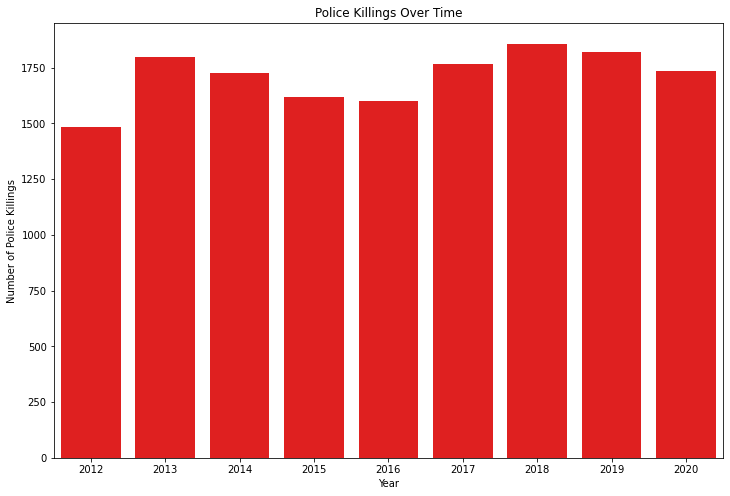

In [31]:
annual_killings = violence_df['Year of Injury'].value_counts().reset_index()
annual_killings.sort_values('Year of Injury', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
annual_killings_plot = sns.barplot(x=annual_killings['index'],y=annual_killings['Year of Injury'],color='r')
annual_killings_plot.set_xlabel("Year")
annual_killings_plot.set_ylabel("Number of Police Killings")
annual_killings_plot.set_title("Police Killings Over Time")
plt.show()

## Assessing disparities in casualties by race

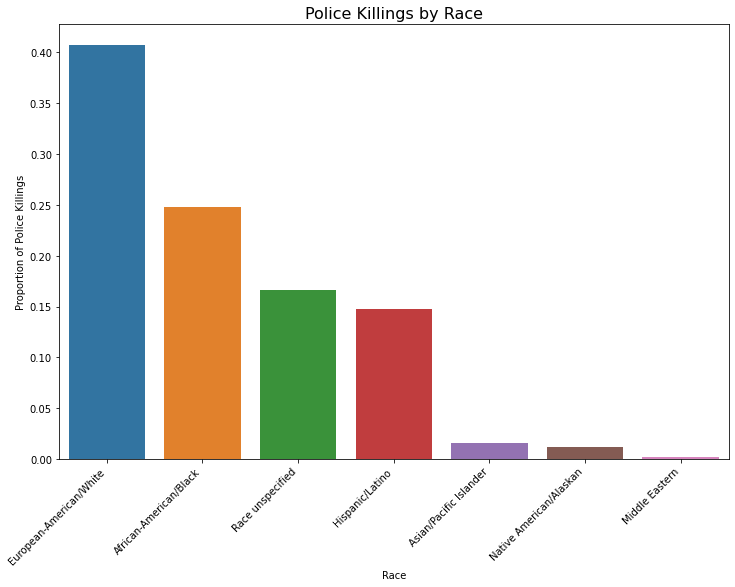

In [32]:
violence_df.loc[(violence_df.Race=='W') | (violence_df.Race=='White'),'Race'] = 'European-American/White'
violence_df.loc[(violence_df.Race=='B') | (violence_df.Race=='Black'),'Race'] = 'African-American/Black'
violence_df.loc[(violence_df.Race=='H') | (violence_df.Race=='Hispanic'),'Race'] = 'Hispanic/Latino'
violence_df.loc[(violence_df.Race=='Unknown race'),'Race'] = 'Race unspecified'
violence_df.loc[(violence_df.Race=='A'),'Race'] = 'Asian/Pacific Islander'
violence_df.loc[(violence_df.Race=='N'),'Race'] = 'Native American/Alaskan'

killings_by_race = violence_df.Race.value_counts().reset_index()
killings_by_race['prop'] = killings_by_race.Race/killings_by_race.Race.sum()
fig, ax = plt.subplots(figsize=(12, 8))
killings_by_race_plot = sns.barplot(x=killings_by_race['index'],y=killings_by_race['prop'])
killings_by_race_plot.set_xticklabels(killings_by_race['index'], rotation=45, horizontalalignment='right')
killings_by_race_plot.set_xlabel("Race")
killings_by_race_plot.set_ylabel("Proportion of Police Killings")
killings_by_race_plot.set_title("Police Killings by Race",fontsize=16)
plt.show()

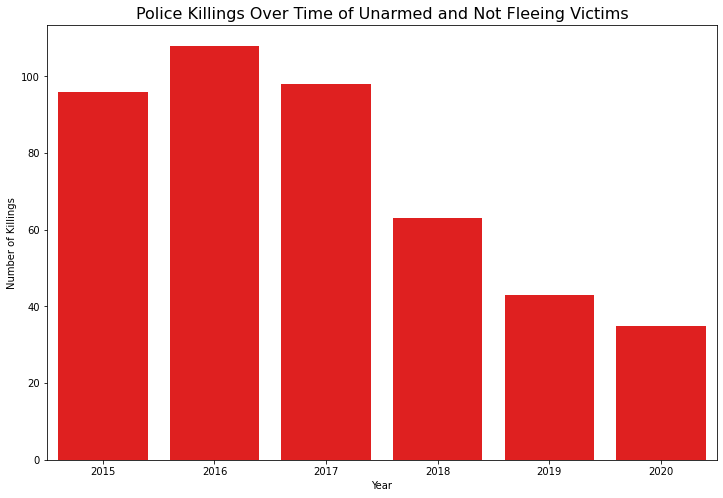

In [33]:
unarmed_killings = violence_df[(violence_df['Unarmed/Did Not Have an Actual Weapon']=='Unarmed/Did Not Have an Actual Weapon') & (violence_df['Fleeing (Source: WaPo)']=='Not fleeing')]
unarmed_killings = unarmed_killings['Year of Injury'].value_counts().reset_index()
unarmed_killings.sort_values('Year of Injury', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
unarmed_killings_plot = sns.barplot(x=unarmed_killings['index'],y=unarmed_killings['Year of Injury'], color='r')
unarmed_killings_plot.set_xlabel("Year")
unarmed_killings_plot.set_ylabel("Number of Killings")
unarmed_killings_plot.set_title("Police Killings Over Time of Unarmed and Not Fleeing Victims",fontsize=16)
plt.show()

## Determining the Outcome Variable and its characteristics

In [34]:
num_cols = [column for column in final_df.columns if (column not in pol_ordinal_vars) and (final_df[column].dtype!='uint8')]
final_df['violence_rate_popserved'] = total_df['violence_rate_popserved']
final_df['violence_level'] = [1 if i >= 90 else 0 for i in final_df['violence_rate_popserved']]
final_df.drop('% Children in Poverty',axis=1,inplace=True)
y = final_df['violence_level']
x_train, x_test, y_train, y_test = train_test_split(final_df.drop(['violence_rate_popserved','violence_level'], axis=1), y, train_size = 0.8, random_state=109)

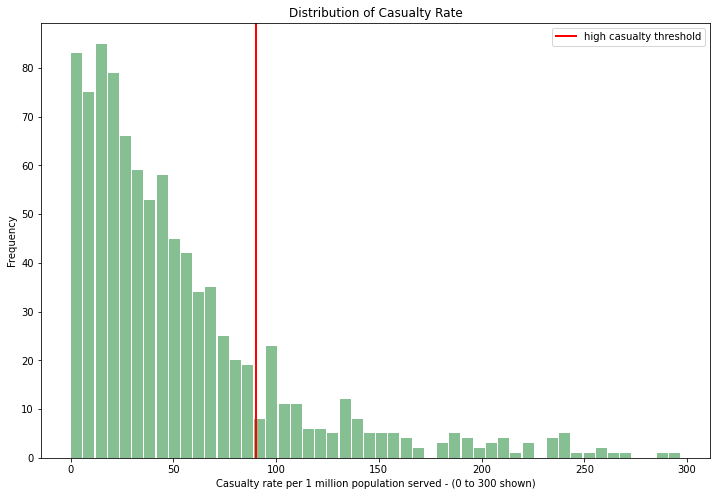

In [35]:
# Outcome Variable Histogram:
ax = final_df["violence_rate_popserved"][final_df["violence_rate_popserved"] < 300].hist(bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_xlabel("Casualty rate per 1 million population served - (0 to 300 shown)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Casualty Rate")
ax.axvline(x= 90, linewidth=2, color='r', label='high casualty threshold')
ax.legend(loc='best')
plt.show()

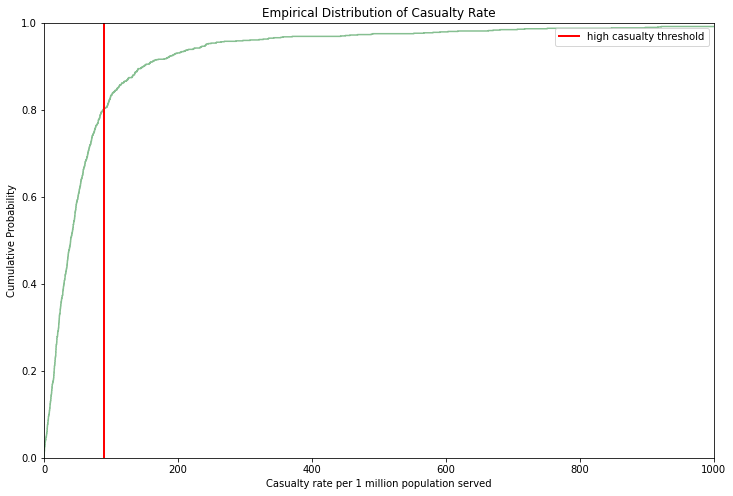

In [36]:
# ECDF Plot of Outcome Variable
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.ecdfplot(final_df.violence_rate_popserved, color='#86bf91')
ax.set(xlim=(0,1000))
ax.axvline(x= 90, linewidth=2, color='r', label='high casualty threshold')
ax.set_xlabel("Casualty rate per 1 million population served")
ax.set_ylabel("Cumulative Probability")
ax.set_title("Empirical Distribution of Casualty Rate")
ax.legend(loc='upper right')
plt.show()

In [37]:
# Calculate Pearson Corr between casualty level and all other predictors
eda_df = x_train.copy()
eda_df['violence_level'] = y_train

eda_corr = eda_df.corr()
eda_corr = eda_corr['violence_level'].reset_index()
eda_corr = eda_corr[eda_corr['index']!='violence_level'].copy()
eda_corr['abs_cor'] = np.abs(eda_corr.violence_level)
eda_corr['pos_cor'] = np.where(eda_corr.violence_level.values > 0,1,0)
eda_corr = eda_corr.sort_values('abs_cor').tail(42)
eda_corr = eda_corr.sort_values('violence_level')

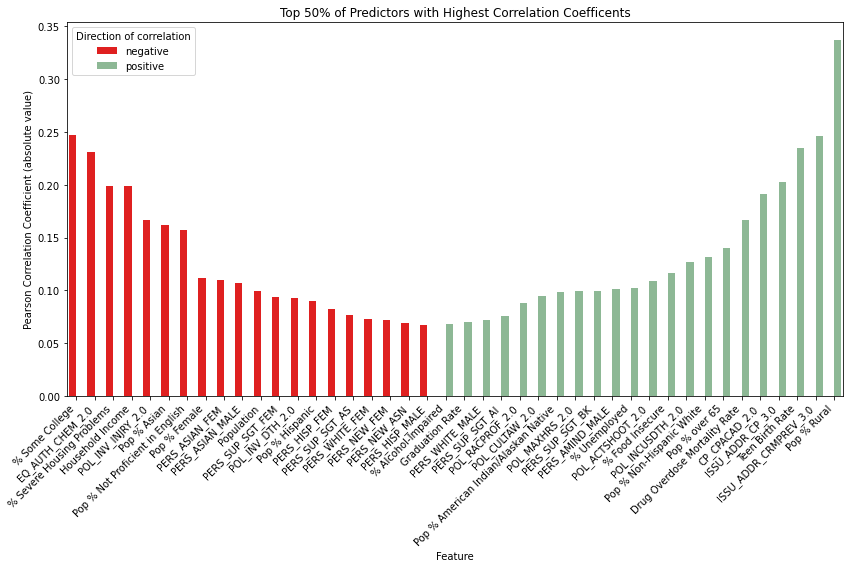

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
corr_plot = sns.barplot(x=eda_corr['index'], y=eda_corr.abs_cor, hue=eda_corr.pos_cor, palette=['r','#86bf91'])
corr_plot.set_xticklabels(eda_corr['index'], rotation=45, horizontalalignment='right')
corr_plot.set_xlabel("Feature")
corr_plot.set_ylabel("Pearson Correlation Coefficient (absolute value)")
corr_plot.set_title("Top 50% of Predictors with Highest Correlation Coefficents")
leg = corr_plot.get_legend()
leg.set_title('Direction of correlation')
new_labels = ['negative', 'positive']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
fig.tight_layout()
plt.show()

fig.savefig("corr_plot.png",transparent=True)

## Assessing distributions of interesting predictors that are in top 30 highest pearson coefficients

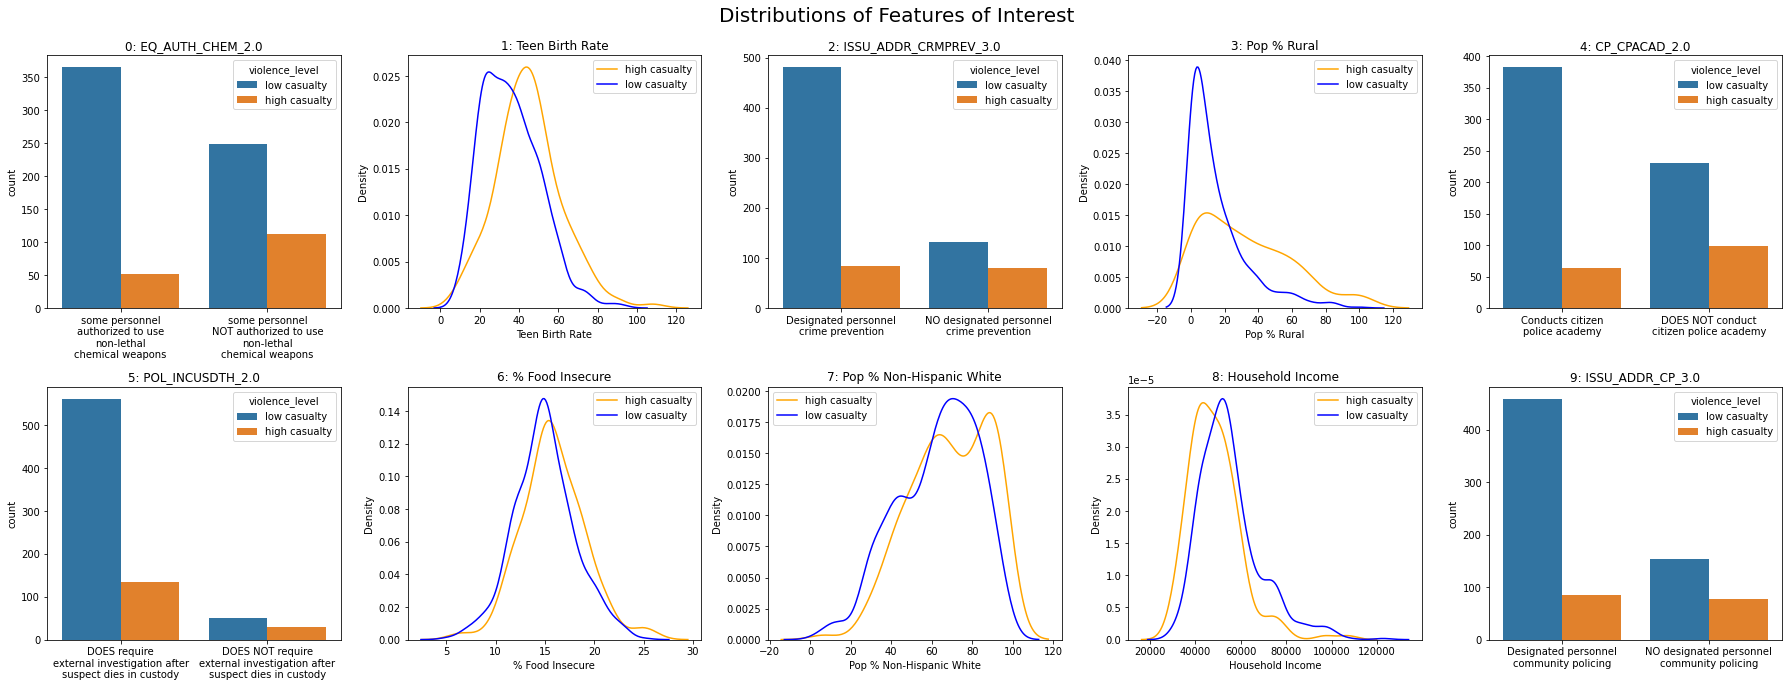

In [39]:
top_vars = eda_corr.sort_values('abs_cor')['index'].tail(30)
top_vars_df = eda_df[top_vars].copy()
top_vars_df['violence_level'] = eda_df['violence_level']

distplots_forpaper = ['EQ_AUTH_CHEM_2.0','Teen Birth Rate','ISSU_ADDR_CRMPREV_3.0','Pop % Rural','CP_CPACAD_2.0','POL_INCUSDTH_2.0',
 '% Food Insecure','Pop % Non-Hispanic White','Household Income','ISSU_ADDR_CP_3.0','violence_level']
top_vars_df_forpaper = top_vars_df[distplots_forpaper].copy()
top_vars_df_forpaper['EQ_AUTH_CHEM_2.0'] = np.where(top_vars_df_forpaper['EQ_AUTH_CHEM_2.0'].values==1,'some personnel\nauthorized to use\nnon-lethal\nchemical weapons','some personnel\nNOT authorized to use\nnon-lethal\nchemical weapons')
top_vars_df_forpaper['ISSU_ADDR_CRMPREV_3.0'] = np.where(top_vars_df_forpaper['ISSU_ADDR_CRMPREV_3.0'].values==1,'NO designated personnel\ncrime prevention','Designated personnel\ncrime prevention')
top_vars_df_forpaper['CP_CPACAD_2.0'] = np.where(top_vars_df_forpaper['CP_CPACAD_2.0'].values==1,'DOES NOT conduct\ncitizen police academy','Conducts citizen\npolice academy')
top_vars_df_forpaper['POL_INCUSDTH_2.0'] =  np.where(top_vars_df['POL_INCUSDTH_2.0'].values==1,'DOES NOT require\nexternal investigation after\nsuspect dies in custody','DOES require\nexternal investigation after\nsuspect dies in custody')
top_vars_df_forpaper['ISSU_ADDR_CP_3.0'] = np.where(top_vars_df_forpaper['ISSU_ADDR_CP_3.0'].values==1,'NO designated personnel\ncommunity policing','Designated personnel\ncommunity policing')
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(5*5,2*5))
for dim, ax in enumerate(axs.ravel()):
    ax.set(title=f"{dim}: {top_vars_df_forpaper.columns[dim]}")
    if top_vars_df_forpaper.columns[dim] in num_cols:
        sns.kdeplot(top_vars_df_forpaper.loc[top_vars_df_forpaper.violence_level==1,top_vars_df_forpaper.columns[dim]], label="high casualty", color='orange', ax=ax)
        sns.kdeplot(top_vars_df_forpaper.loc[top_vars_df_forpaper.violence_level==0,top_vars_df_forpaper.columns[dim]], label="low casualty",color='blue', ax=ax)
        ax.legend()
    else:
        count_plot = sns.countplot(x=top_vars_df_forpaper[top_vars_df_forpaper.columns[dim]], hue=top_vars_df_forpaper.violence_level, ax=ax)
        leg = count_plot.get_legend()
        count_plot.set_xlabel(None)
        new_labels = ['low casualty', 'high casualty']
        for t, l in zip(leg.texts, new_labels): 
            t.set_text(l)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Distributions of Features of Interest', fontsize=20)
plt.show()

fig.savefig("features_of_interest_plot.png",transparent=True)

### Final Preprocessing of Data (standardizing, downsampling, drop missing data)

In [41]:
# EMIL'S PREPROCESSING
# Create the percentage missing function
def perc_missing(df):
    # Uses percentages (so when you want to say give me missing columns over 5 percent, use "5" not "0.05")
    missing = (df.isna().sum()/len(df))*100
    
    return missing

#Create df2, replacing all the columns that has more than 1 percent missing variables
perc_missing(final_df)
cols_to_remove = final_df.columns[perc_missing(final_df) > 1]
df2 = final_df.drop(cols_to_remove, axis=1)
print(perc_missing(df2))

#df3 removes all rows with missing values
df3 = df2.dropna()

#Check how many rows were dropped
print(final_df.shape)
print(df3.shape)

num_cols_df3 = []
for col in df3.columns:
    if len(df3[col].value_counts()) > 10:
        num_cols_df3.append(col)



#X = df3.drop(["violence_level", "violence_rate_popserved"], axis =1)
X = df3.drop(["violence_level", "violence_rate_popserved",'PERS_COLBAR_SWN'], axis =1)
X['CP_TRN_INSRV'] = X['CP_TRN_INSRV'].astype(int)
y = df3["violence_level"].values

num_cols = [column for column in X.columns if (X[column].dtype=='float64')]

pol_ordinal_vars = ['PERS_COLBAR_SWN','CP_TRN_NEW','CP_TRN_INSRV']
#pol_ordinal_vars = ['CP_TRN_NEW','CP_TRN_INSRV']
pol_nominal_vars = ['CP_MISSION','CP_PLAN','CP_CPACAD','ISSU_ADDR_CP','EQ_AUTH_NECK',
                    'EQ_AUTH_CHEM','POL_MAXHRS','POL_MENTILL','POL_INCUSDTH','POL_RACPROF',
                    'POL_ACTSHOOT','POL_STFRSK','POL_FOOT','POL_MSCOND','POL_BWC',
                    'POL_CULTAW','POL_INV_INJRY','POL_INV_DTH','POL_CCRB','ISSU_ADDR_CRMPREV']

for column in X.columns:
  if (column not in pol_ordinal_vars) and (X[column].dtype=='int64'): 
    X[column] = X[column].astype('uint8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) 



scaler = StandardScaler().fit(X_train[num_cols])
X_trainstd = X_train.copy()
X_teststd = X_test.copy()
X_trainstd[num_cols] = scaler.transform(X_trainstd[num_cols])
X_teststd[num_cols] = scaler.transform(X_teststd[num_cols])
rus = RandomUnderSampler(random_state=200)
X_train_downsamp, y_train_downsamp = rus.fit_sample(X_trainstd, y_train)


% Alcohol-Impaired                              0.000000
Teen Birth Rate                                 0.103093
% Uninsured under 65                            0.000000
Graduation Rate                                 0.618557
% Unemployed                                    0.000000
Violent Crime Rate                              0.721649
% Severe Housing Problems                       0.000000
% Food Insecure                                 0.000000
Population                                      0.000000
Pop % < 18                                      0.000000
Pop % over 65                                   0.000000
Pop % African American                          0.000000
Pop % American Indian/Alaskan Native            0.000000
Pop % Asian                                     0.000000
Pop % Native Hawaiian/Other Pacific Islander    0.000000
Pop % Hispanic                                  0.000000
Pop % Non-Hispanic White                        0.000000
Pop % Not Proficient in English

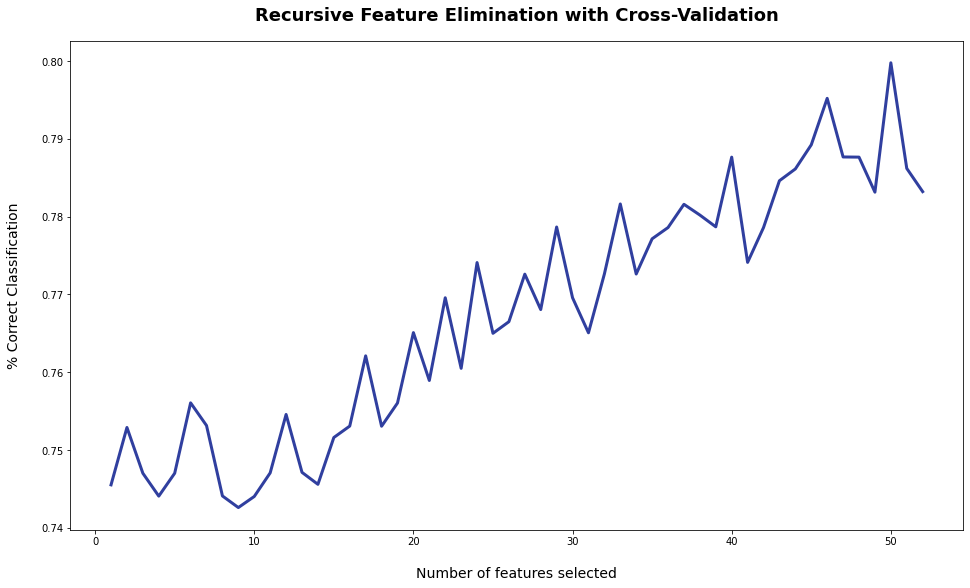

In [42]:
#Recursive Feature Elimination 
rfc = RandomForestClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_trainstd, y_train)

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

### Logistic GAM with Police Race Predictors

In [43]:
#Logistic Lam we are using!!
lams = np.logspace(-3,3,20)

log_gam = LogisticGAM(max_iter= 5000, n_splines = 5).gridsearch(X_train_downsamp.values, y_train_downsamp, lam=lams)
log_gam.summary()

N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.8/site-packages/pygam/links.py:134: RuntimeWarning: invalid value

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     52.9465
Link Function:                        LogitLink Log Likelihood:                                  -124.9612
Number of Samples:                          252 AIC:                                              355.8154
                                                AICc:                                             385.9003
                                                UBRE:                                                 3.58
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2846
Feature Function                  Lam

<ipython-input-43-91ed9a7b5ea0>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam.summary()


In [45]:
yhat = log_gam.predict(X_teststd)
pos_acc = accuracy_score(y_test[np.where(y_test==1)], yhat[np.where(y_test==1)])
neg_acc = accuracy_score(y_test[np.where(y_test==0)], yhat[np.where(y_test==0)])

model_acc = log_gam.accuracy(X_teststd, y_test)
print(f'The overall model accuracy is {model_acc:.5f}. The accuracy of predictions for response variables of 1 is {pos_acc:.5f}. The accuracy of predictions for response variables of 0 is {neg_acc:.5f}')

The overall model accuracy is 0.72982. The accuracy of predictions for response variables of 1 is 0.71930. The accuracy of predictions for response variables of 0 is 0.73246


In [46]:
#Eli-5 interpretation 

def score(X, y):
    y_pred = log_gam.predict(X)
    return accuracy_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_teststd.values, y_test, n_iter=50, random_state=109)
feature_importances = np.mean(score_decreases, axis=0)
feat_imp = pd.DataFrame({'Feature': list(X_trainstd.columns), 'Importance': list(feature_importances)})
feat_imp.sort_values(by='Importance', ascending=False, inplace = True)

tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()


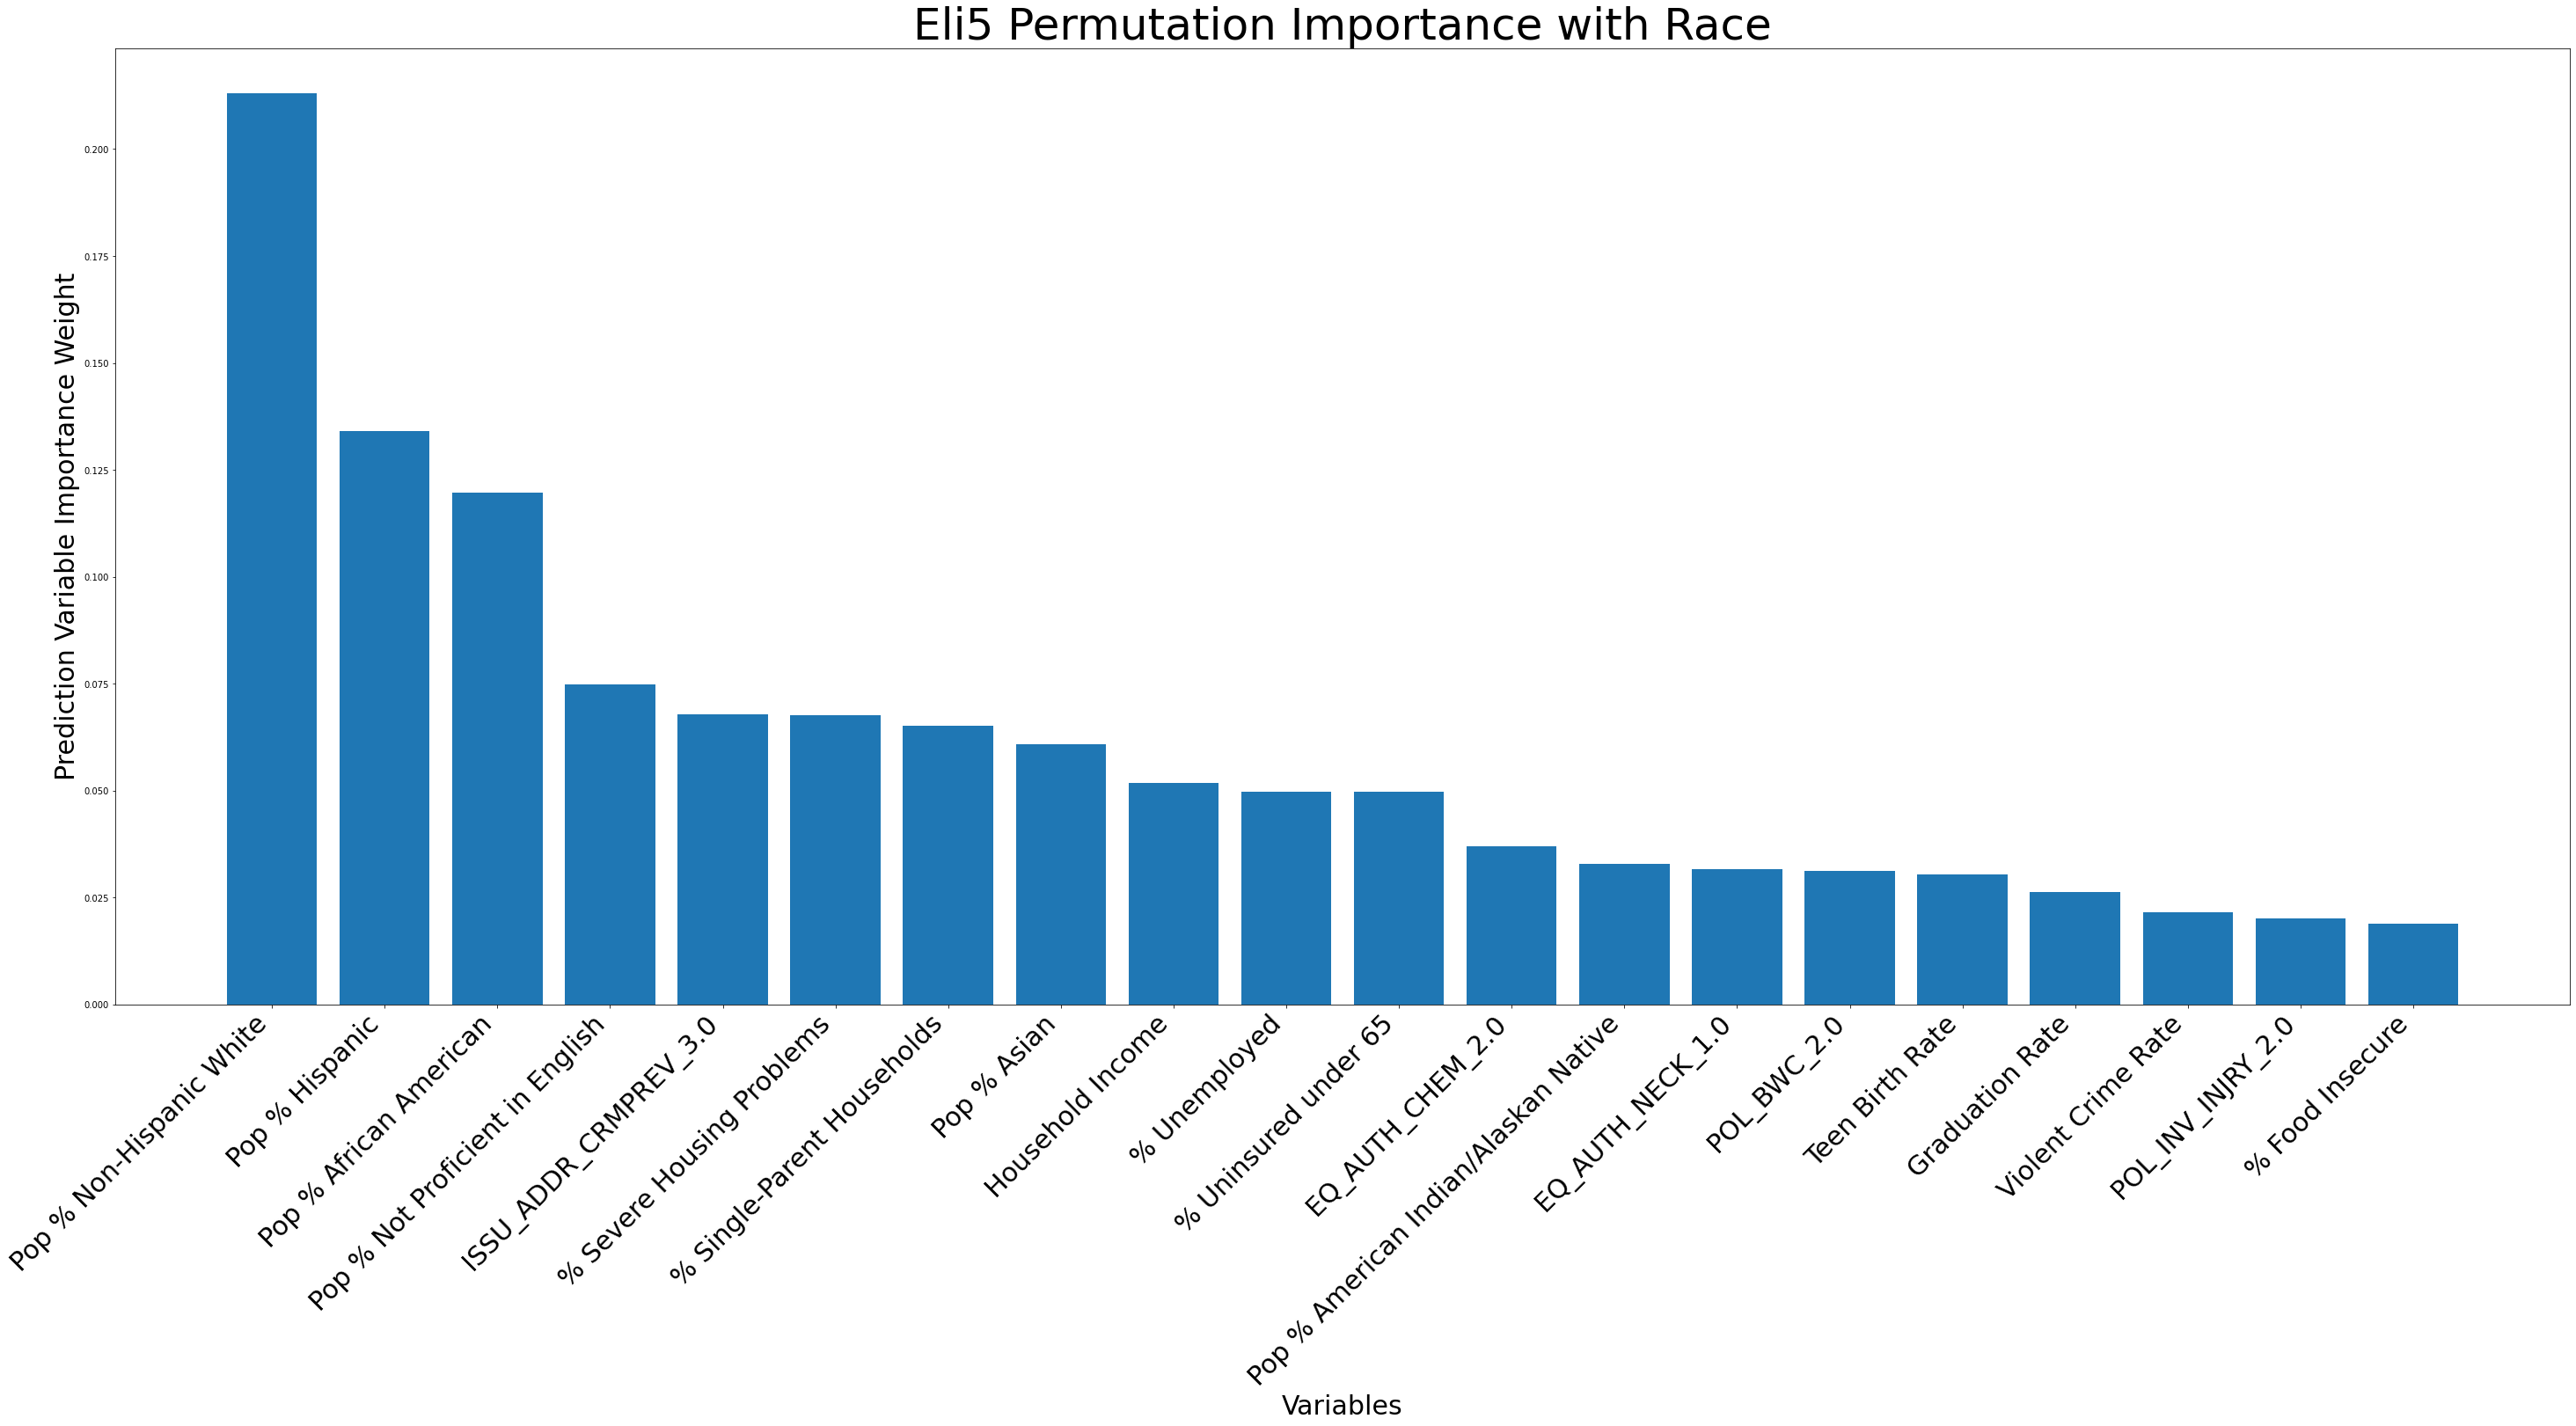

In [47]:
#Feature Importance for Model with Race data 
plt.figure(figsize = (50,20))
plt.bar(feat_imp.head(20)['Feature'],feat_imp.head(20)['Importance'])
plt.ylabel('Prediction Variable Importance Weight',fontsize=30)
plt.xlabel('Variables',fontsize=30)
plt.title('Eli5 Permutation Importance with Race',fontsize=50)
plt.xticks(rotation=45, horizontalalignment='right',fontsize=30)
plt.show()

In [48]:
#FPR and AUC for Model with Race Variables 
fpr = fp/(fp+tn) * 100
tpr = tp/(tp+fn) * 100 
precision = tp/(tp+fp)

print(f'The false positive rate is {fpr:.4f}')

y_probs = log_gam.predict_proba(X_teststd)
auc = roc_auc_score(y_test, y_probs)

print(f'The AUC for our model is {auc:.5f}')

The false positive rate is 26.7544
The AUC for our model is 0.76347


<Figure size 432x288 with 0 Axes>

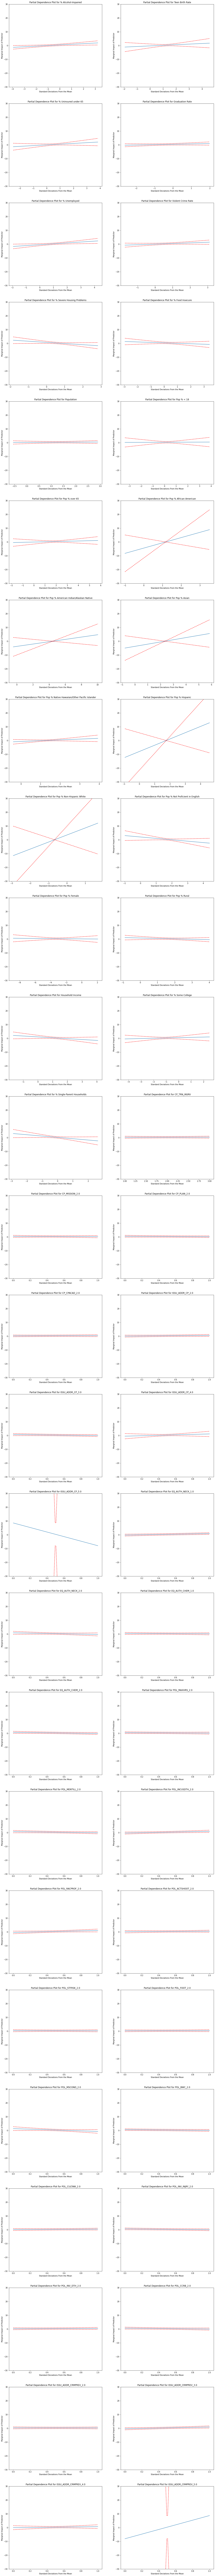

In [49]:
#Partial Plots for Model with Race Data
titles = X_train_downsamp.columns
fig=plt.figure()
plt.figure(figsize = (20,50))
plot_count = 1
for i, term in enumerate(log_gam.terms):
    if term.isintercept:
        continue
    XX = log_gam.generate_X_grid(term=i)
    pdep, confi = log_gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.subplot(26, 2, plot_count)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.xlabel('Standard Deviations From the Mean')
    plt.ylabel('Marginal Impact of Predictor')
    plt.title(f'Partial Dependence Plot for {titles[i]}')
    plt.ylim(-30,30)
    plot_count+=1
    plt.subplots_adjust(top=4)

### Logistic GAM without Police Race Predictors

In [50]:
#Logistic GAM model without race 
race_preds = ['Pop % African American',
       'Pop % American Indian/Alaskan Native', 'Pop % Asian',
       'Pop % Native Hawaiian/Other Pacific Islander', 'Pop % Hispanic',
       'Pop % Non-Hispanic White']
X_train_downsamp_norace = X_train_downsamp.drop(race_preds, axis =1)

lams = np.logspace(-3,3,20)

log_gam_norace = LogisticGAM(max_iter= 5000, n_splines =5).gridsearch(X_train_downsamp_norace.values, y_train_downsamp, lam=lams)
log_gam_norace.summary()

N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.8/site-packages/pygam/links.py:134: RuntimeWarning: invalid value

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      46.946
Link Function:                        LogitLink Log Likelihood:                                  -126.7167
Number of Samples:                          252 AIC:                                              347.3254
                                                AICc:                                             370.4401
                                                UBRE:                                               3.5273
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2745
Feature Function                  Lam

<ipython-input-50-7072c31fb1d7>:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam_norace.summary()


In [52]:
X_teststd_norace = X_teststd.drop(race_preds, axis =1)
yhat_norace = log_gam_norace.predict(X_teststd_norace)
pos_acc_norace = accuracy_score(y_test[np.where(y_test==1)], yhat_norace[np.where(y_test==1)])
neg_acc_norace = accuracy_score(y_test[np.where(y_test==0)], yhat_norace[np.where(y_test==0)])

model_acc_norace = log_gam_norace.accuracy(X_teststd_norace, y_test)

print(f'The overall model accuracy with no race data is {model_acc_norace:.5f}. The accuracy of predictions for response variables of 1 is {pos_acc_norace:.5f}. The accuracy of predictions for response variables of 0 is {neg_acc_norace:.5f}')

The overall model accuracy with no race data is 0.72632. The accuracy of predictions for response variables of 1 is 0.73684. The accuracy of predictions for response variables of 0 is 0.72368


In [53]:
#ELi-5 Variable Importance and fp rate 
def score(X, y):
    y_pred = log_gam_norace.predict(X)
    return accuracy_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_teststd_norace.values, y_test, n_iter=50, random_state=109)
feature_importances = np.mean(score_decreases, axis=0)
feat_imp_norace = pd.DataFrame({'Feature': list(X_teststd_norace.columns), 'Importance': list(feature_importances)})
feat_imp_norace.sort_values(by='Importance', ascending=False, inplace = True)

tn, fp, fn, tp = confusion_matrix(y_test, yhat_norace).ravel()

In [54]:
#FPR and AUC for Model without Race Variables 
fpr_norace = fp/(fp+tn) * 100
tpr_norace = tp/(tp+fn) * 100 
precision = tp/(tp+fp)

print(f'The false positive rate is {fpr_norace:.4f}')

y_probs = log_gam_norace.predict_proba(X_teststd_norace)
auc_norace = roc_auc_score(y_test, y_probs)

print(f'The AUC for our model is {auc_norace:.5f}')

The false positive rate is 27.6316
The AUC for our model is 0.75492


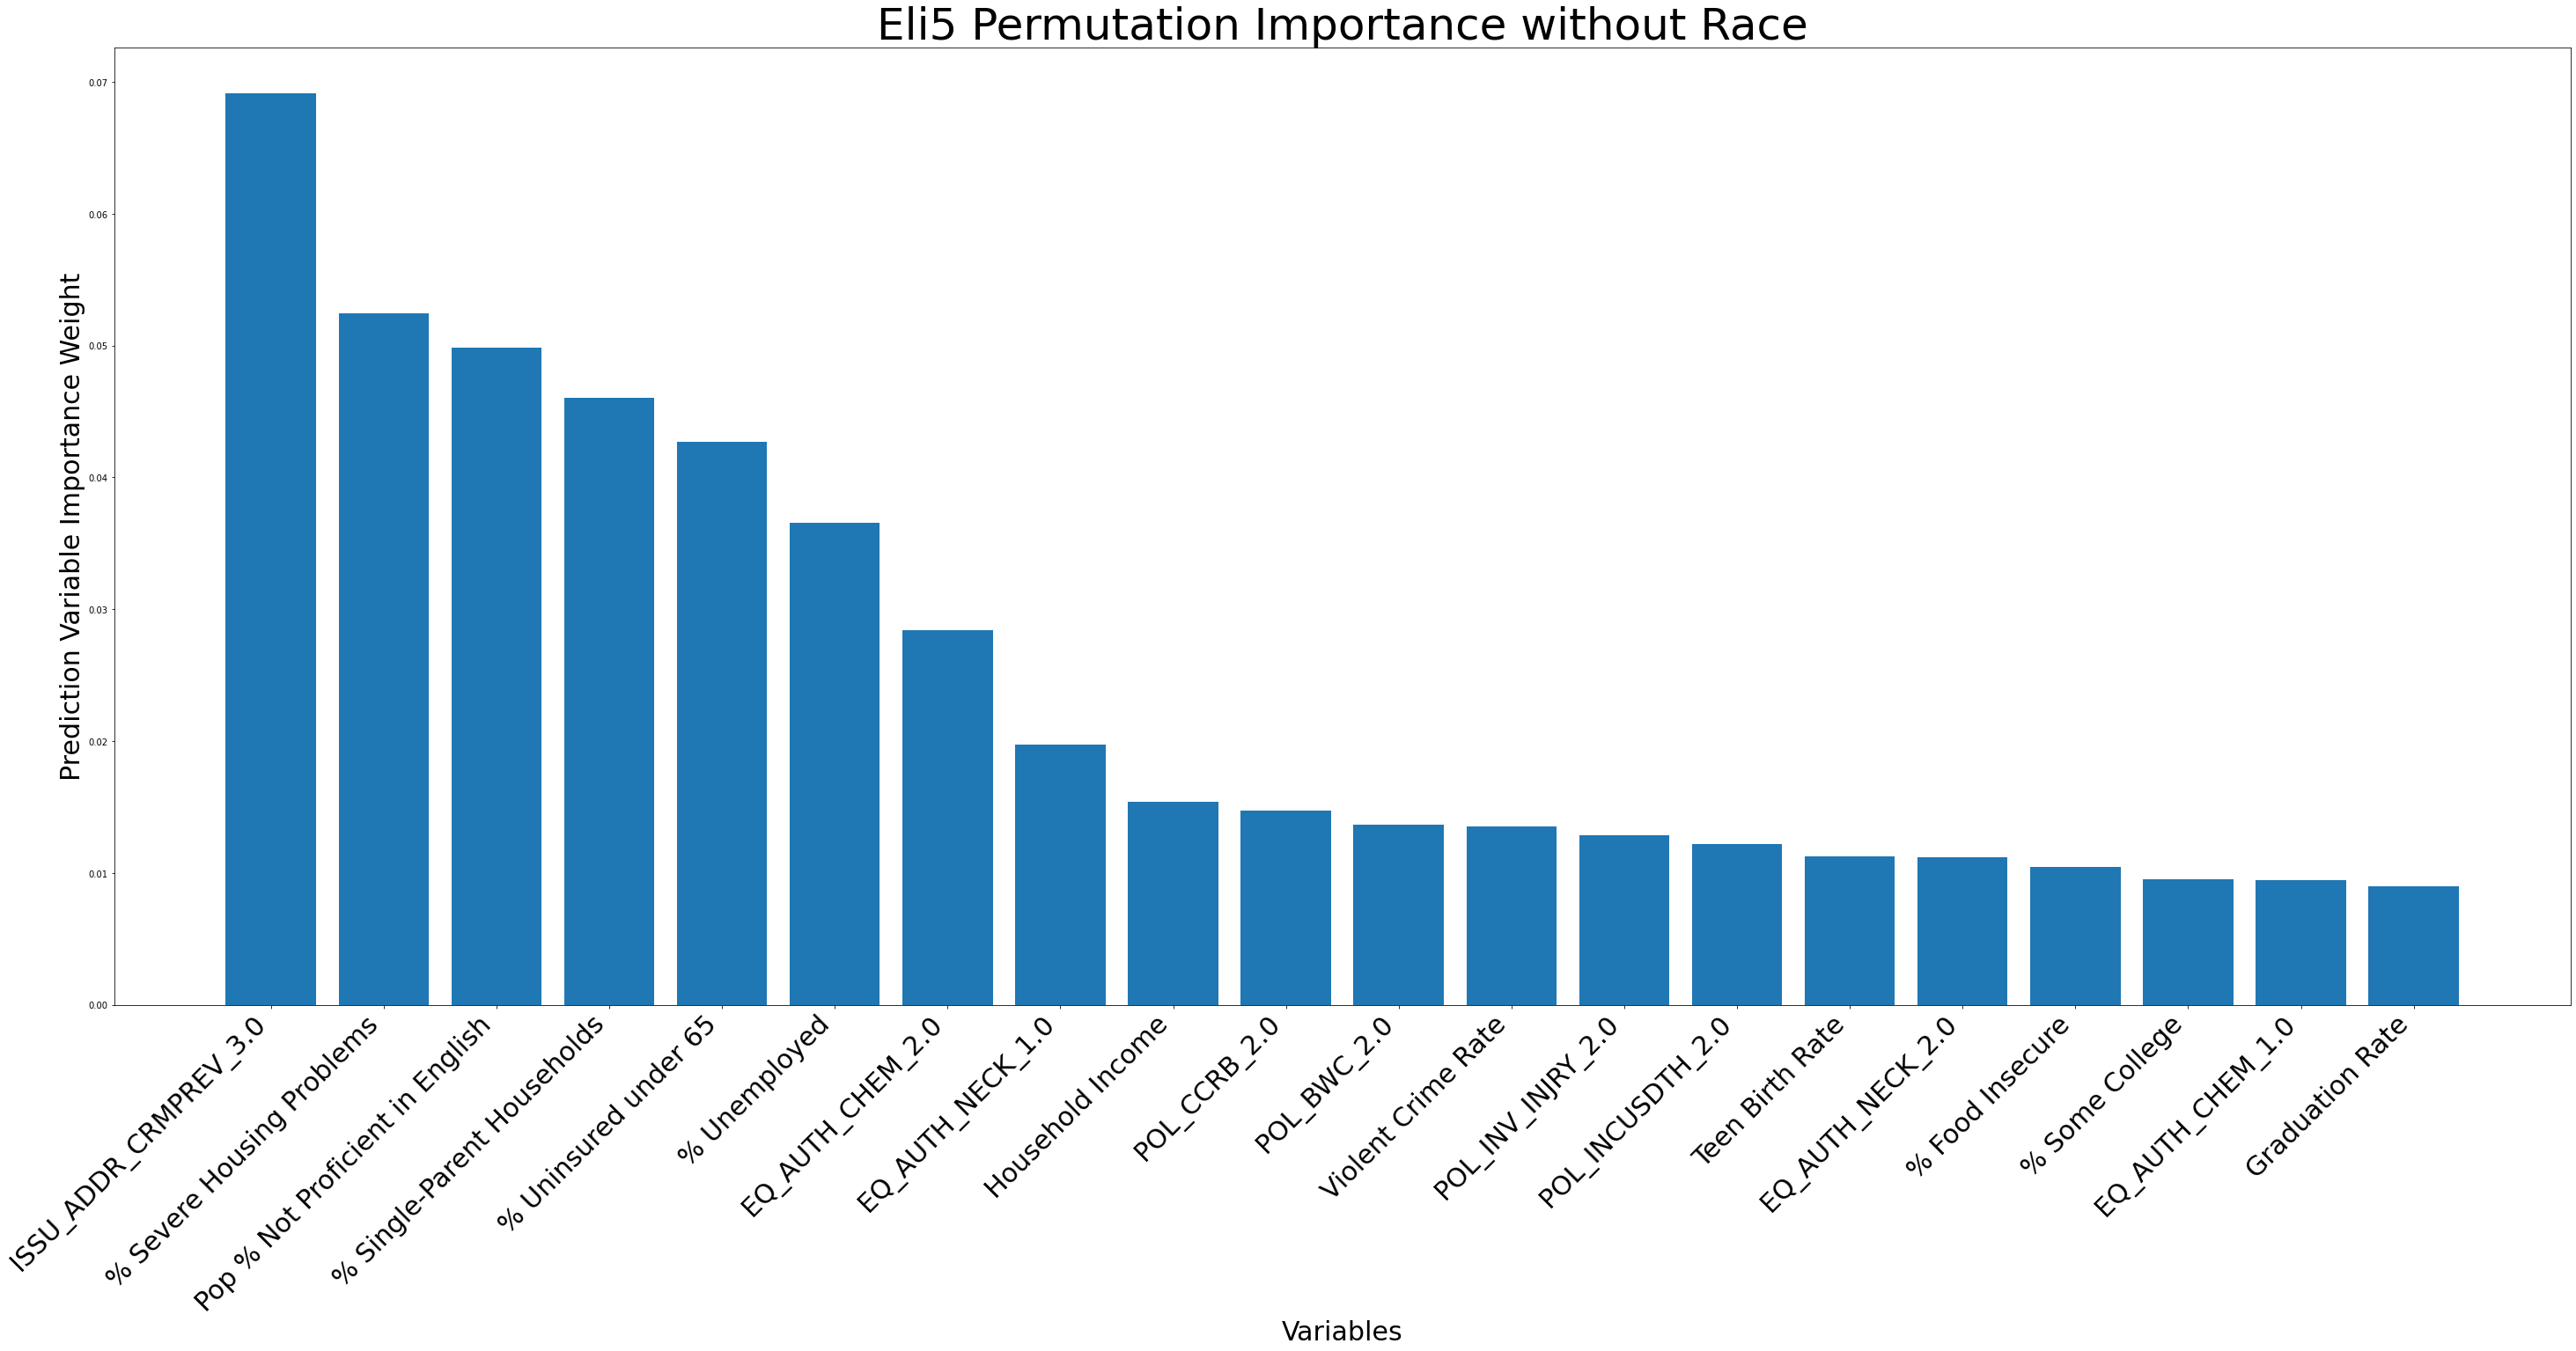

In [55]:
#Feature Importance for Model without Race data 
plt.figure(figsize = (50,20))
plt.bar(feat_imp_norace.head(20)['Feature'],feat_imp_norace.head(20)['Importance'])
plt.ylabel('Prediction Variable Importance Weight',fontsize=30)
plt.xlabel('Variables',fontsize=30)
plt.title('Eli5 Permutation Importance without Race',fontsize=50)
plt.xticks(rotation=45, horizontalalignment='right',fontsize=30)
plt.show()

In [57]:
#Rasim Code with Imputations

X = final_df.drop(["violence_level", "violence_rate_popserved",'PERS_COLBAR_SWN'], axis =1)
#X['CP_TRN_INSRV'] = X['CP_TRN_INSRV'].astype(int)
y = final_df["violence_level"].values

num_cols = [column for column in X.columns if (X[column].dtype=='float64')]

pol_ordinal_vars = ['PERS_COLBAR_SWN','CP_TRN_NEW','CP_TRN_INSRV']
#pol_ordinal_vars = ['CP_TRN_NEW','CP_TRN_INSRV']
pol_nominal_vars = ['CP_MISSION','CP_PLAN','CP_CPACAD','ISSU_ADDR_CP','EQ_AUTH_NECK',
                    'EQ_AUTH_CHEM','POL_MAXHRS','POL_MENTILL','POL_INCUSDTH','POL_RACPROF',
                    'POL_ACTSHOOT','POL_STFRSK','POL_FOOT','POL_MSCOND','POL_BWC',
                    'POL_CULTAW','POL_INV_INJRY','POL_INV_DTH','POL_CCRB','ISSU_ADDR_CRMPREV']

for column in X.columns:
  if (column not in pol_ordinal_vars) and (X[column].dtype=='int64'): 
    X[column] = X[column].astype('uint8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) 



scaler = StandardScaler().fit(X_train[num_cols])
X_trainstd = X_train.copy()
X_teststd = X_test.copy()
X_trainstd[num_cols] = scaler.transform(X_trainstd[num_cols])
X_teststd[num_cols] = scaler.transform(X_teststd[num_cols])
rus = RandomUnderSampler(random_state=200)
X_train_downsamp, y_train_downsamp = rus.fit_sample(X_trainstd, y_train)


#KNN imputation 
knnimpute = KNNImputer(n_neighbors=2).fit(X_trainstd)
x_trainknn = knnimpute.transform(X_trainstd)
x_trainknn = pd.DataFrame(x_trainknn, columns= list(X_trainstd.columns), index = X_trainstd.index)
x_testknn = knnimpute.transform(X_teststd)
x_testknn = pd.DataFrame(x_testknn, columns= list(X_teststd.columns), index = X_teststd.index)

# Downsampling
rus = RandomUnderSampler(random_state= 200)
X_train_downsampimp, y_train_downsampimp = rus.fit_sample(x_trainknn, y_train)
#X_train_downsampimp.drop('% Children in Poverty', axis = 1, inplace =True)
#x_testknn.drop('% Children in Poverty', axis = 1, inplace =True)


In [58]:
#Logistic Gam with imputed data
lams = np.logspace(-3,3,20)

logimp_gam = LogisticGAM(max_iter= 10000, n_splines = 4).gridsearch(X_train_downsampimp.values, y_train_downsampimp, lam = lams, objective ='UBRE')
logimp_gam.summary()

N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
/usr/local/lib/python3.8/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.8/site-packages/pygam/links.py:134: RuntimeWarning: invalid value

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    100.2941
Link Function:                        LogitLink Log Likelihood:                                    -69.818
Number of Samples:                          286 AIC:                                              340.2242
                                                AICc:                                             453.0328
                                                UBRE:                                               3.4701
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6478
Feature Function                  Lam

<ipython-input-58-c7c806fc39fe>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  logimp_gam.summary()


In [62]:
yhat_imp = logimp_gam.predict(x_testknn)
pos_acc_imp = accuracy_score(y_test[np.where(y_test==1)], yhat_imp[np.where(y_test==1)])
neg_acc_imp = accuracy_score(y_test[np.where(y_test==0)], yhat_imp[np.where(y_test==0)])

model_acc_imp = logimp_gam.accuracy(x_testknn, y_test)

print(f'The overall model accuracy with imputed data is {model_acc_imp:.5f}. The accuracy of predictions for response variables of 1 is {pos_acc_imp:.5f}. The accuracy of predictions for response variables of 0 is {neg_acc_imp:.5f}')

The overall model accuracy with imputed data is 0.66667. The accuracy of predictions for response variables of 1 is 0.64583. The accuracy of predictions for response variables of 0 is 0.67078
